In [1]:
import torch
from matplotlib import pyplot as plt
from torch.optim import Adam
from gpytorch.optim import NGD

from alfi.models import generate_multioutput_rbf_gp
from alfi.plot import Plotter1d
from alfi.utilities.torch import softplus
from alfi.impl.odes import RNAVelocityLFM, RNAVelocityConfiguration
from alfi.datasets import SingleCellKidney, Pancreas
from alfi.impl.trainers import EMTrainer

import numpy as np

In [2]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
dataset = Pancreas(data_dir='../../data')
cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]

In [26]:
def print_scatter(cells, gene_index, num_connections=10, figsize=(3, 3), colors=None):
    traj = lfm.current_trajectory
    u = traj[:2000].detach()  # (num_genes, 100)
    s = traj[2000:].detach()  # (num_genes, 100)
    u_y = cells[:2000]  # (num_genes, num_cells)
    s_y = cells[2000:]  # (num_genes, num_cells)

    plt.figure(figsize=figsize)
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index], color='red')

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], alpha=0.1,s=5, c='black')

    # Plot timepoint choices
    for timepoint in range(lfm.timepoint_choices.shape[0]):
        plt.scatter(s[gene_index, timepoint], u[gene_index, timepoint], s=4, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, lfm.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, lfm.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')

In [4]:
num_cells = dataset[0].shape[1]
num_outputs = 4000
num_latents = 10
num_inducing = 50  # (I x m x 1)
end_t = 12
use_natural = False

config = RNAVelocityConfiguration(
    num_samples=30,
    num_cells=num_cells,
    end_pseudotime=end_t
)

print('Number of cells:', num_cells)
print('Number of latent GPs (# transcription rates):', num_latents)

step_size = 1e-1

inducing_points = torch.linspace(0, end_t, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, end_t, 80, dtype=torch.float32)

gp_model = generate_multioutput_rbf_gp(num_latents, inducing_points,
                                       use_scale=False, initial_lengthscale=3,
                                       gp_kwargs=dict(natural=use_natural))

Number of cells: 3696
Number of latent GPs (# transcription rates): 10


In [5]:
data = dataset.m_observed.squeeze()
print(data.shape)
y_target = data
u_y = y_target[:2000]  # (num_genes, num_cells)
s_y = y_target[2000:]  # (num_genes, num_cells)
# w = torch.logical_and(u_y > 0, s_y > 0)
# u_y = torch.gather(u_y, dim=1, index=w)
print(s_y.shape)
x = s_y > torch.tensor(np.percentile(s_y, 98, axis=1)).unsqueeze(-1)
s = s_y * x
x = u_y > torch.tensor(np.percentile(u_y, 98, axis=1)).unsqueeze(-1)
u = u_y * x
s = s.unsqueeze(-1)
u = u.unsqueeze(1)
gamma = torch.matmul(u, s).squeeze()
l2 = s.squeeze().square().sum(dim=1)
gamma /= l2
gamma = gamma.unsqueeze(-1)
print(gamma.max(), gamma.min())

torch.Size([4000, 3696])
torch.Size([2000, 3696])
tensor(37.4716) tensor(0.)


In [6]:
data = dataset.m_observed
cells = data.permute(1, 2, 0)  # (O, C, 1)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
nonzero_mask = list()
for gene_index in range(num_outputs // 2):
    nonzero_mask.append(torch.logical_and(s_y[gene_index, :, 0] > 0,
                                     u_y[gene_index, :, 0] > 0))
nonzero_mask = torch.stack(nonzero_mask).repeat(2, 1)

lfm_kwargs = dict(
    nonlinearity=softplus,
    decay_rate=gamma,
    num_training_points=num_cells,
    nonzero_mask=nonzero_mask
)
lfm = RNAVelocityLFM(num_outputs, gp_model, config, **lfm_kwargs)



if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_cells, lr=0.05)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [torch.optim.Adam(lfm.parameters(), lr=0.06)]
trainer = EMTrainer(lfm, optimizers, dataset, batch_size=4000)
plotter = Plotter1d(lfm, dataset.gene_names)

### Outputs prior to training:

<function softplus at 0x00000277046B1168>
torch.Size([3696])


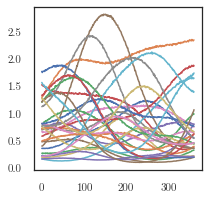

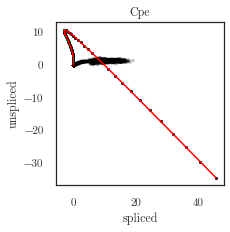

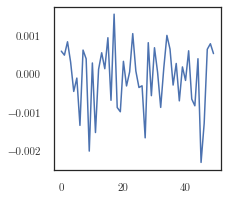

In [7]:
t = inducing_points
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
num_samples = 3
s = lfm.sample_latents(t_f, num_samples)
print(lfm.nonlinearity)
plt.figure(figsize=(3, 3))
for i in range(num_latents):
    for sample in range(num_samples):
        plt.plot(s[sample, :, i].detach())

data = next(iter(trainer.data_loader))
cells = data.permute(0, 2, 1) # (O, C, 1)
print_scatter(cells, cpe_index, num_connections=0)
plt.figure(figsize=(3, 3))
mean = list(lfm.gp_model.variational_parameters())[0]
plt.plot(mean.detach()[0])
print(lfm.time_assignments_indices.shape)

In [53]:

import time
start = time.time()

output = trainer.train(5, report_interval=1, step_size=1e-1)
end = time.time()
print(end - start)

estep done
num t2: torch.Size([8])
tensor(2.0295e+08, dtype=torch.float64, grad_fn=<SumBackward0>)
back
ward
Epoch 009/013 - Loss: 18830.95 (18830.92 0.03) kernel: [2.786024  2.5345316 2.5513866 2.8638873 2.7268999 2.797174  2.5816476
 2.8474734 2.5674496 3.0349748]
estep done
num t2: torch.Size([9])
tensor(2.0287e+08, dtype=torch.float64, grad_fn=<SumBackward0>)
back
ward
Epoch 010/013 - Loss: 18336.04 (18336.01 0.03) kernel: [2.735419  2.4805808 2.4971988 2.8141634 2.6774328 2.7440798 2.5323503
 2.7952943 2.5357609 2.9993255]
estep done
num t2: torch.Size([9])
tensor(2.0276e+08, dtype=torch.float64, grad_fn=<SumBackward0>)
back
ward
Epoch 011/013 - Loss: 17873.67 (17873.63 0.04) kernel: [2.6830366 2.4296215 2.4443548 2.7648926 2.6269357 2.689543  2.4833598
 2.7414856 2.5061142 2.9619875]
estep done
num t2: torch.Size([10])
tensor(2.0256e+08, dtype=torch.float64, grad_fn=<SumBackward0>)
back
ward
Epoch 012/013 - Loss: 17437.05 (17437.00 0.04) kernel: [2.629018  2.384128  2.391389  2.7

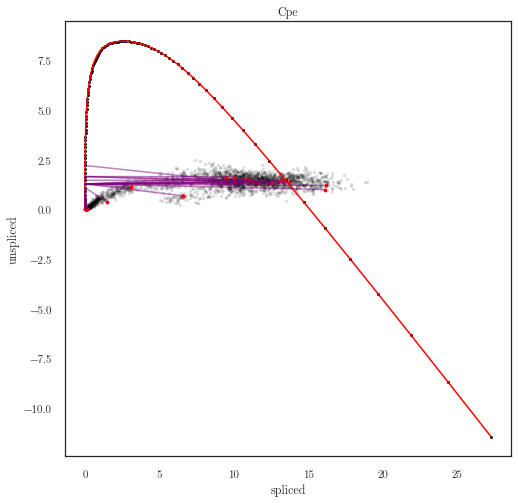

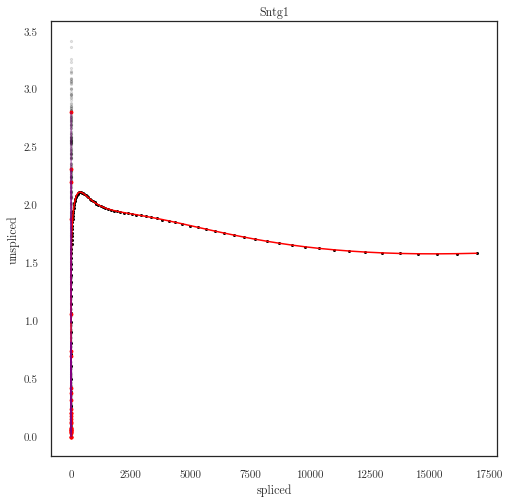

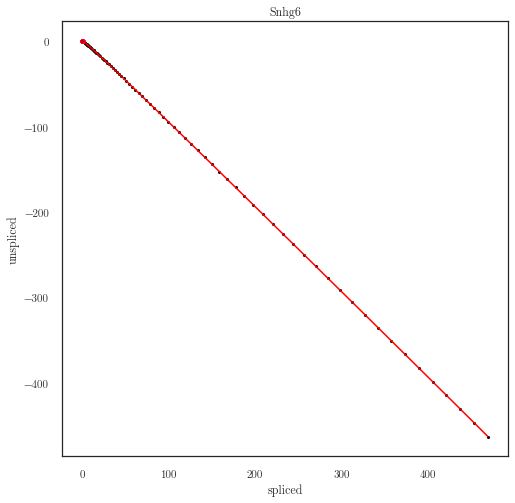

In [54]:
# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

out = lfm(lfm.timepoint_choices, step_size=step_size)

for i in [cpe_index] + list(range(0, 2)):
    print_scatter(cells, i, num_connections=30, figsize=(8, 8))

In [9]:
savefile = './rna-1106'
do_save = False
if do_save:
    lfm.save(savefile)

do_load = False
if do_load:
    lfm = RNAVelocityLFM.load(savefile,
                              gp_model=gp_model,
                              lfm_args=[lfm.num_outputs, config],
                              lfm_kwargs=lfm_kwargs)


    optimizer = torch.optim.Adam(lfm.parameters(), lr=0.1)
    trainer = EMTrainer(lfm, [optimizer], dataset, batch_size=4000)
print(do_load)

False


torch.Size([3696, 4000])


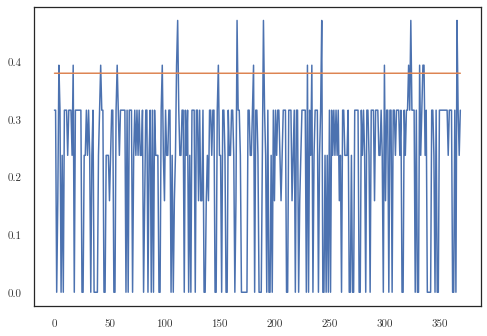

In [10]:
#0, -3 15
#0 -2 0 3
out = lfm(lfm.timepoint_choices, step_size=step_size)
print(out.mean.shape)
out = out.mean.t().detach()
u_out = out[:2000].squeeze()
s_out = out[2000:].squeeze()
plt.plot(u_out[cpe_index, ::10])
plt.plot(-s_out[cpe_index, ::10] + 0.38)
# plt.plot(s_out[cpe_index, ::10], u_out[cpe_index, ::10])
# plt.plot(s_out[cpe_index, ::10])

tensor(6)


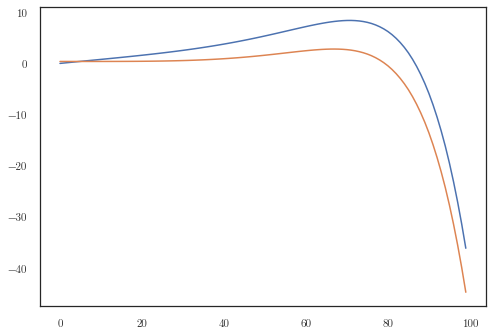

In [11]:
print(lfm.time_assignments_indices.max())
u_out = lfm.current_trajectory[:2000].detach()
s_out = lfm.current_trajectory[2000:].detach()
plt.plot(u_out[cpe_index])
plt.plot(-s_out[cpe_index] + 0.38)

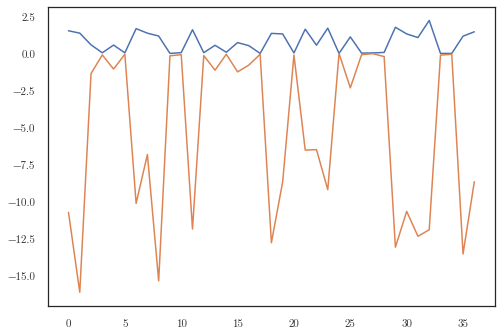

In [20]:
plt.plot(u_y[cpe_index, ::100])
plt.plot(-s_y[cpe_index, ::100])

# plt.scatter(s_y[cpe_index, ::10], u_y[cpe_index, ::10], alpha=0.1,s=5, c='black')

In [14]:
out = lfm(lfm.timepoint_choices, step_size=step_size)

In [31]:
mean = out.mean.t()
print(cells.shape, mean.shape)
# print(cells.squeeze()[0])
# print(cells.squeeze()[2000])
# print((cells.squeeze() * nonzero_mask)[2000].nonzero())
# with torch.no_grad():
#     # lfm.splicing_rate[cpe_index] += 0.2
#     lfm.transcription_rate[cpe_index] += 0.5
print(lfm.decay_rate[cpe_index])
print(lfm.splicing_rate[cpe_index])
print(lfm.transcription_rate[cpe_index])

torch.Size([4000, 3696, 1]) torch.Size([4000, 3696])
tensor([0.], grad_fn=<SelectBackward>)
tensor([0.4723], dtype=torch.float64, grad_fn=<SelectBackward>)
tensor([1.2801], dtype=torch.float64, grad_fn=<SelectBackward>)


In [16]:
print(l2[cpe_index])
print(gamma.shape)
print(gamma.min())
print(gamma.max())
# s_low = s_y[s_sort_ind[-50:]]
# print(s_low)
# u_y.shape, s_y.shape

tensor(19980.4258)
torch.Size([2000, 1])
tensor(0.)
tensor(37.4716)


torch.Size([4000, 3696])
torch.Size([4000, 100])
torch.Size([100]) torch.Size([2000, 3696])


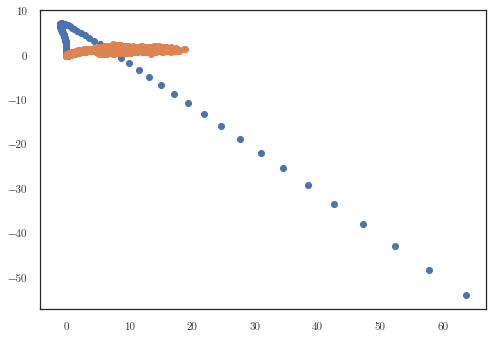

In [17]:
print(y_target.shape)
print(lfm.current_trajectory.shape)
u = lfm.current_trajectory[:2000].detach()[cpe_index]
s = lfm.current_trajectory[2000:].detach()[cpe_index]
u_y = y_target[:2000]  # (num_genes, num_cells)
s_y = y_target[2000:]  # (num_genes, num_cells)
print(u.shape, u_y.shape)
plt.scatter(s, u)
plt.scatter(s_y[cpe_index], u_y[cpe_index])

IndexError: too many indices for tensor of dimension 1

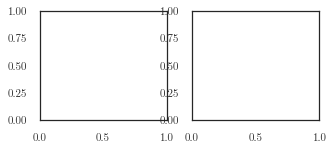

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(5, 2))
axes[0].plot(u[:, cpe_index])
axes[1].plot(s[:, cpe_index])

### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=0)


torch.Size([2000, 3696, 1]) torch.Size([2000, 100, 1])
4000


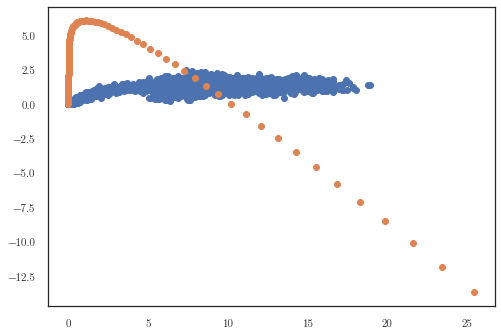

In [51]:
from alfi.utilities.torch import ceil
for i, data in enumerate(trainer.data_loader):
    y = data.permute(0, 2, 1)  # (O, C, 1)
batch_size = 500
num_batches = ceil(y.shape[1] / batch_size)
u_y = y[:num_outputs//2]  # (num_genes, num_cells)
s_y = y[num_outputs//2:]  # (num_genes, num_cells)
plt.scatter(s_y[cpe_index, :, 0], u_y[cpe_index, :, 0])
plt.scatter(s[cpe_index, :, 0], u[cpe_index, :, 0])
print(u_y.shape, s.shape)
print(num_batches * 500)
time_ass = torch.clone(lfm.time_assignments_indices)
for batch in range(num_batches):
    from_index = batch * batch_size
    to_index = (batch+1) * batch_size
    u_residual = u_y[:, from_index:to_index] - u.transpose(1, 2)
    s_residual = s_y[:, from_index:to_index] - s.transpose(1, 2)

    residual = u_residual.square() + s_residual.square()
    residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
    # print(residual.shape)
    # print(residual[:5])
    # print('done', batch)
    time_ass[from_index:to_index] = residual

torch.Size([4000, 3696, 1])
torch.Size([2000, 3696, 1]) torch.Size([2000, 1, 100])
torch.Size([500, 3696, 100])
1710
torch.Size([500, 3696, 100])
torch.Size([3696])
min torch.Size([500, 100])



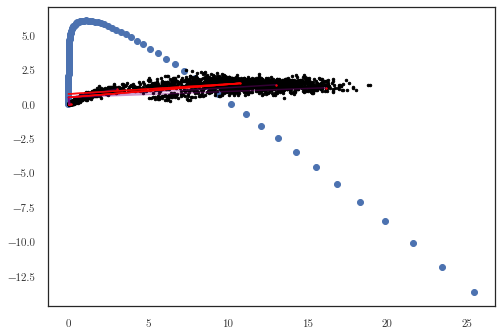

In [52]:
data = next(iter(trainer.data_loader))
y = data.permute(0, 2, 1)  # (O, C, 1)
print(y.shape)

traj = lfm.current_trajectory
u = traj[:2000].detach().unsqueeze(2)  # (num_genes, 100, 1)
s = traj[2000:].detach().unsqueeze(2)  # (num_genes, 100, 1)
u_y = y[:2000]  # (num_genes, num_cells)
s_y = y[2000:]  # (num_genes, num_cells)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[1500:] - u[1500:].transpose(1, 2)
s_residual = s_y[1500:] - s[1500:].transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
residual_indices = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = cpe_index
print(gene_index)
print(residual.shape)
# residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort(descending=True)
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=6, c='black')
print()#torch.cat([
# for cell_index in residual_sort_indices[-900:]:#, residual_indices[torch.randperm(residual_indices.shape[0])[:1]]]):
for cell_index in range(10):
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=2, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.4, c='purple')

    line = [
        (s[gene_index, time_ass[cell_index]], s_y[gene_index, i, 0]),
        (u[gene_index, time_ass[cell_index]], u_y[gene_index, i, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.5, c='red')

# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)

In [ ]:
n
import scvelo as scv
scv.tl.velocity(dataset.loom)

In [ ]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [ ]:
velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)